# import, set sampler

In [1]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [2]:
# f1 = open("freetokenPN.txt", "r")
# f2 = open("paidtoken.txt", "r")
# freetokenPN=f1.read()
# paidtoken=f2.read()

f1 = open("../token.txt", "r")
f2 = open("../paid_token.txt", "r")
freetokenVDT=f1.read()
paidtoken=f2.read()


#sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=freetoken)
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=freetokenVDT)

print("QPU {} was selected.".format(sampler.solver.name))


QPU Advantage2_prototype1.1 was selected.


# get nodes and coups

In [5]:
#get the couplers and nodes classification
with open('nodes_class.pkl', 'rb') as file:
    nodes_class = pickle.load(file)
with open('coups_class.pkl', 'rb') as file:
    coups_class = pickle.load(file)

print('imported embedding dictionaries')
print('')

    #check J_11, 12 and 22 couplers
count = [0,0,0,0]
for coup in coups_class:
    if coups_class[coup]=='K2':
        count[0] += 1
        #final_coups.update({coup:k2})
    elif coups_class[coup]=='J11':
        count[1] += 1
        #final_coups.update({coup:jafm})
    elif coups_class[coup]=='J12':
        count[2] += 1
        #final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
    elif coups_class[coup]=='J22':
        count[3] += 1
        #final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
    else:
        print("error")
print('number of couplers per type')
print("K_FM | J_11 | J_12 | J_22")
print(count)
    

imported embedding dictionaries

number of couplers per type
K_FM | J_11 | J_12 | J_22
[31, 366, 64, 0]


# functions

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [7]:
def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

In [8]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [9]:
def DocName(jafm,k2,h1,s):
    
    str1="J="+str(jafm)
    str2="h1,k2,s="+str(h1)+","+str(k2)+","+str(s)
    now = datetime.now()
    str3 = now.strftime("%m-%d-%y__%H-%M-%S")
    
    Documentname=str1+'__'+str2+'__'+str3
    
    return Documentname

# anneal offsets

In [11]:
data = pd.read_excel('./annealing_schedule.xlsx',  sheet_name='processor-annealing-schedule') 
s_vals = pd.DataFrame(data, columns=['s'])
A_vals = pd.DataFrame(data, columns=['A(s) (GHz)'])
B_vals = pd.DataFrame(data, columns=['B(s) (GHz)'])
cs_vals = pd.DataFrame(data, columns=['C (normalized)'])
first_s = s_vals.to_numpy().flatten()
first_A = A_vals.to_numpy().flatten()
first_B = B_vals.to_numpy().flatten()
first_c = cs_vals.to_numpy().flatten()


In [12]:
new_s = np.linspace(0,1,num = 100*len(first_s))
new_A = np.interp(new_s, first_s, first_A)
new_B = np.interp(new_s, first_s, first_B)
new_c = np.interp(new_s, first_s, first_c)

A2divB = np.divide(new_A**2,new_B)

indices = len(new_A)*np.ones(len(new_A),dtype=np.int8)
# delta_c = np.zeros(len(new_A))
differences = np.zeros(len(new_A))

for i in range(len(new_A)):
    val = find_nearest(A2divB, value = new_A[i])
    differences[i]= A2divB[val] - new_A[i]
    indices[i] = val 
    

In [13]:
hoffset_s = np.divide(new_B,2*new_B[indices])
J22_s = np.divide(new_B,new_B[indices])
J12_s = np.divide(2*new_B,new_B + new_B[indices])
delta_c = new_c[indices] - new_c


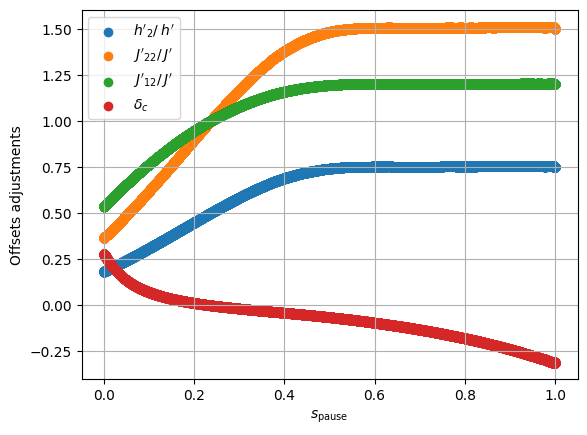

In [14]:
#h value, J_12, J_22
fig, ax = plt.subplots()

ax.scatter(new_s, hoffset_s, label=r"$h'_2/\:h'$")
ax.scatter(new_s, J22_s, label=r"$J'_{22}/\:J'$")
ax.scatter(new_s, J12_s, label=r"$J'_{12}/\:J'$")
ax.scatter(new_s, delta_c, label=r"$\delta_c$")

plt.legend()
#ax.set_yscale('log')
plt.xlabel(r'$s_{\rm pause}$')
plt.ylabel(r'Offsets adjustments')
plt.grid()
plt.show()


# params

In [56]:
splist= np.round(sorted(list(np.arange(0.15,0.651,0.05)) + [0.275,0.325,0.375,0.425, 0.475, 0.525]),3)
print('splist')
print(splist, len(splist))

Nreads_measure = 1000
Nreps = 25
Nreads_shim = 100
Nreps_shim = 50
alpha = float(3e-6)

hoverjlist = np.round(sorted(list(np.linspace(0,4.5,10)) + [0.25, 0.75, 1.25,1.75,2.25,2.75,3.25,3.75,4.25]),3)
hlist = np.array(hoverjlist) * (1 / np.max(J12_s))
print('h/J list')
print(hoverjlist, len(hoverjlist))
print('total points in (h,sp) = ', len(splist)*len(hoverjlist))
print('')
print('the bare hlist')
print(hlist)

#import sublatt_dict for mag measurement
sublatt_dict = np.load("sublatt_dict.npy", allow_pickle=True).tolist()

splist
[0.15  0.2   0.25  0.275 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475
 0.5   0.525 0.55  0.6   0.65 ] 17
h/J list
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5 ] 19
total points in (h,sp) =  323

the bare hlist
[0.         0.20767127 0.41534254 0.62301381 0.83068508 1.03835636
 1.24602763 1.4536989  1.66137017 1.86904144 2.07671271 2.28438398
 2.49205525 2.69972653 2.9073978  3.11506907 3.32274034 3.53041161
 3.73808288]


In [44]:
print("bare value of J, dictated by the rescaling of J_12 or J_22")
jafm = 1.0/np.max(J12_s)
k2 = -2.0
print('J_AF = ', jafm)
print('K = ', k2)

bare value of J, dictated by the rescaling of J_12 or J_22
J_AF =  0.8306850848192522
K =  -2.0


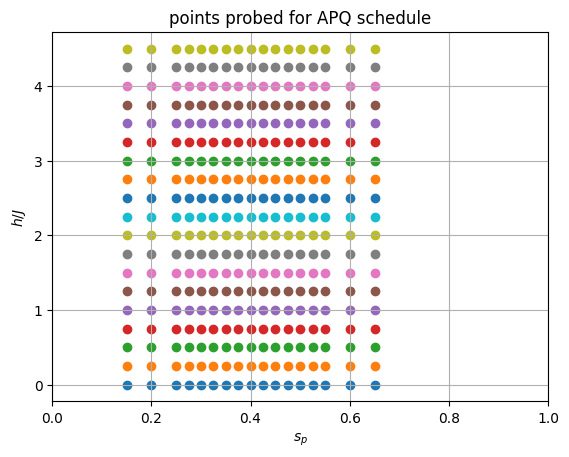

In [57]:
for hj in hoverjlist:
    plt.scatter(splist, hj*np.ones(len(splist)))
plt.title('points probed for APQ schedule')
plt.xlabel(r'$s_p$')
plt.ylabel(r'$h/J$')
plt.grid()
plt.xlim([0, 1.0])
plt.show()

# time estimate

In [58]:

times_big = []

file1 = open("output.txt", "w")  # write mode
file1.write("Timing chart, shimming + measurement \n")

for h1_run in hlist:

    h1val = h1_run
    times = []
        
    for j in range(len(splist)):
        sp = splist[j]
#         print("sp=",sp)
        spindex = find_nearest(new_s, sp)
        hbias = [0] * sampler.properties['num_qubits']


        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = sampler.nodelist.index(node)
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")
                
            final_nodes=sorted(list(final_hs.keys()))

        
        
        # reverse quench - pause - forward quench
        #rev_sch = [[0.0, 1.0], [(1 - sp), sp], [(1 - sp) + tpause, sp],
        #           [2 * (1 - sp) + tpause, 1]]

        anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
                    [100 + 1000*sp + (1-sp), 1]]
                    
        time_allreps=[]

        Nreads = Nreads_shim
        for rep in range(Nreps_shim):
            time =  sampler.solver.estimate_qpu_access_time(
                    num_qubits=len(final_nodes),
                    anneal_schedule=anneal_pause_quench_sch,
                    num_reads=Nreads,
                    answer_mode = "raw",
                    anneal_offsets = offsets,
                    flux_drift_compensation=False,
                    flux_biases = hbias, 
                    readout_thermalization=100.,
                    auto_scale=False)
            time_allreps.append(time)

        Nreads = Nreads_measure
        for rep in range(Nreps_shim, Nreps + Nreps_shim): 
            time =  sampler.solver.estimate_qpu_access_time(
                    num_qubits=len(final_nodes),
                    anneal_schedule=anneal_pause_quench_sch,
                    num_reads=Nreads,
                    answer_mode = "raw",
                    anneal_offsets = offsets,
                    flux_drift_compensation=False,
                    flux_biases = hbias, 
                    readout_thermalization=100.,
                    auto_scale=False)
            time_allreps.append(time)

                
        times.append(sum(time_allreps))
        print("s_p= ", sp, " time= ", sum(time_allreps))
        file1.write("s_p= " + str(sp) + " time= " + str(sum(time_allreps)/1000000) + " seconds \n")

    print("h1= ", h1val, " time= ", sum(times))
    file1.write("h1= " + str(h1val) + " time= " + str(sum(times)/1000000) + " seconds \n")
    times_big.append(sum(times))
    print("")
    file1.write(" \n")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds OR", sum(times_big) / 1000000 /60, "minutes")
file1.write("anneal pause quench anneal access time" + str(sum(times_big) / 1000000) + "seconds OR " + str(sum(times_big) / 1000000 /60) + "minutes")
print("all done")

file1.close()


s_p=  0.15  time=  12827729.556355515
s_p=  0.2  time=  14326229.556355515
s_p=  0.25  time=  15824729.556355515
s_p=  0.275  time=  16573979.556355514
s_p=  0.3  time=  17323229.556355514
s_p=  0.325  time=  18072479.556355514
s_p=  0.35  time=  18821729.55635551
s_p=  0.375  time=  19570979.556355514
s_p=  0.4  time=  20320229.556355514
s_p=  0.425  time=  21069479.556355514
s_p=  0.45  time=  21818729.556355514
s_p=  0.475  time=  22567979.556355514
s_p=  0.5  time=  23317229.556355514
s_p=  0.525  time=  24066479.556355514
s_p=  0.55  time=  24815729.556355514
s_p=  0.6  time=  26314229.556355514
s_p=  0.65  time=  27812729.556355514
h1=  0.0  time=  345443902.45804375

s_p=  0.15  time=  12827729.556355515
s_p=  0.2  time=  14326229.556355515
s_p=  0.25  time=  15824729.556355515
s_p=  0.275  time=  16573979.556355514
s_p=  0.3  time=  17323229.556355514
s_p=  0.325  time=  18072479.556355514
s_p=  0.35  time=  18821729.55635551
s_p=  0.375  time=  19570979.556355514
s_p=  0.4  ti

# anneal pause quench

In [53]:
times_big = []
for i in range(len(hlist)):
    h1val = hlist[i]
    print("h/j=", hoverjlist[i], "h1=",h1val)
       
    jafm = 1.0/np.max(J22_s)
    k2 = -2.0
    
    times = []
    for j in range(len(splist)):
        sp = round(splist[j],2)
        spindex = find_nearest(new_s, sp)
        print("start s_p=", sp)

        #starting values for shimming
        hbias = [0] * sampler.properties['num_qubits']
        mi_init = [0] * len(nodes_class)

        all_biases = []
        all_mag_per_qubit = []



        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex] * jafm })
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex] * jafm })
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = node
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")

            final_nodes=sorted(list(final_hs.keys()))


        for o in range(len(offsets)):
            offsetval = offsets[o]
            offsetrange = sampler.properties['anneal_offset_ranges'][o]
            if (offsetval<offsetrange[0] or offsetval>offsetrange[1]):
                print(o, "is bad", "offset range is", offsetrange)
            

        anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
                    [100 + 1000*sp + (1-sp), 1]]

        time_allreps=[]
        
        #add shimming here for 40 steps, 100 reads
        #then, measurement
        #Nreps with continued shimming
        ######
        #shimming
        ######
        Nreads = Nreads_shim
        for rep in range(Nreps_shim):
            all_biases.append(hbias)
            response =  sampler.sample_ising(
                        h=final_hs,
                        J=final_coups,
                        anneal_schedule=anneal_pause_quench_sch,
                        num_reads=Nreads,
                        anneal_offsets = offsets, 
                        flux_drift_compensation=False,
                        flux_biases = hbias, 
                        answer_mode = 'raw',
                        readout_thermalization=100.,
                        auto_scale=False)

            ###
            #extract the avg mag per used qubit
            ###

            #number of runs in resp
            Nruns=response.record.shape[0]
            #make a list of qubits used
            qubitl=[]
            for qubit in response.variables:
                qubitl.append(qubit)
            #calculate the magnetization of each qubit over all runs
            #and make a magnetization list for each qubit
            magl=[]
            for i in range(len(qubitl)):
                #list of spins from all runs for qubit - i
                spinl=[]
                for run in range(Nreads):
                    spin=response.record[run][0][i]
                    spinl.append(spin)
                avgspin=(sum(spinl))/(len(spinl))
                magl.append(avgspin)
                
            qm_ar=np.array([qubitl,magl])
            all_mag_per_qubit.append(magl)

            ### 
            #update the hbias
            ###
            #which qubits to measure for majority rule for total magnetization
            used_qubits = np.array(qubitl, dtype = int)
            indices_to_measure = []
            for qubit in sublatt_dict.keys():
                indices_to_measure.append(np.where(used_qubits == qubit)[0][0])

            #this is the avg system magnetization
            avg_m = np.mean(magl[indices_to_measure])
            
            #hifluxl = [0] * sampler.properties['num_qubits']
            count2 = 0
            modifications = np.zeros(len(hbias))
            for node in range(sampler.properties['num_qubits']):
                if node in nodes_class:
                    modifications[node] = (-alpha)*(magl[count2] - avg_m)
                    count2 += 1
            hbias = hbias + modifications

            ####
            #extract the time taken
            ####

            time = response.info['timing']['qpu_access_time']
            time_allreps.append(time)

            folder = Path(
               "/Users/prathunarasimhan/Desktop/APQ redo 1/raw"
                + "/" + "h1=" + str(h1val) 
                + "/" + "s=" + str(sp))
            folder.mkdir(parents=True, exist_ok=True)
            Name = DocName(jafm, k2, h1val, sp) + "_" + str(rep)
            filepath = Path(folder, Name)



            paramsarray = set_params_array({
                    'jafm': jafm,
                    'k2': k2,
                    'h1': h1val,
                    'Nreads': Nreads,
                    'sp' : sp,
                    'shim-or-measure' : 'shim'
                })

            resp = response.record
            np.savez(
            filepath,
            resp=resp,
            paramsarray=paramsarray,
            final_nodes=final_nodes,
            flux_bias_used = hbias,
            mag_array = magl
            )

        #the last hbias is fed into this

        ######
        #measurement + shimming
        ######
        Nreads = Nreads_measure
        for rep in range(Nreps_shim, Nreps + Nreps_shim): 
            all_biases.append(hbias)
            response =  sampler.sample_ising(
                        h=final_hs,
                        J=final_coups,
                        anneal_schedule=anneal_pause_quench_sch,
                        num_reads=Nreads,
                        anneal_offsets = offsets, 
                        flux_drift_compensation=False,
                        flux_biases = hbias, 
                        answer_mode = 'raw',
                        readout_thermalization=100.,
                        auto_scale=False)

            ###
            #extract the avg mag per used qubit
            ###

            #number of runs in resp
            Nruns=response.record.shape[0]
            #make a list of qubits used
            qubitl=[]
            for qubit in response.variables:
                qubitl.append(qubit)
            #calculate the magnetization of each qubit over all runs
            #and make a magnetization list for each qubit
            magl=[]
            for i in range(len(qubitl)):
                #list of spins from all runs for qubit - i
                spinl=[]
                for run in range(Nreads):
                    spin=response.record[run][0][i]
                    spinl.append(spin)
                avgspin=(sum(spinl))/(len(spinl))
                magl.append(avgspin)
                
            qm_ar=np.array([qubitl,magl])
            all_mag_per_qubit.append(magl)

            ### 
            #update the hbias
            ###
            #which qubits to measure for majority rule for total magnetization
            used_qubits = np.array(qubitl, dtype = int)
            indices_to_measure = []
            for qubit in sublatt_dict.keys():
                indices_to_measure.append(np.where(used_qubits == qubit)[0][0])

            #this is the avg system magnetization
            avg_m = np.mean(magl[indices_to_measure])
            
            #hifluxl = [0] * sampler.properties['num_qubits']
            count2 = 0
            modifications = np.zeros(len(hbias))
            for node in range(sampler.properties['num_qubits']):
                if node in nodes_class:
                    modifications[node] = (-alpha)*(magl[count2] - avg_m)
                    count2 += 1
            hbias = hbias + modifications

            ####
            #extract the time taken
            ####

            time = response.info['timing']['qpu_access_time']
            time_allreps.append(time)

            folder = Path(
               "/Users/prathunarasimhan/Desktop/APQ redo 1/raw"
                + "/" + "h1=" + str(h1val) 
                + "/" + "s=" + str(sp))
            folder.mkdir(parents=True, exist_ok=True)
            Name = DocName(jafm, k2, h1val, sp) + "_" + str(rep)
            filepath = Path(folder, Name)



            paramsarray = set_params_array({
                    'jafm': jafm,
                    'k2': k2,
                    'h1': h1val,
                    'Nreads': Nreads,
                    'sp' : sp,
                    'shim-or-measure' : 'measure'
                })

            #save the response
            resp = response.record
            np.savez(
            filepath,
            resp=resp,
            paramsarray=paramsarray,
            final_nodes=final_nodes,
            flux_bias_used = hbias,
            mag_array = magl
            )


        times.append(sum(time_allreps))
        print("s_p=", sp, "time=", sum(time_allreps))

        #save the mag, hbias and qubits for the (h,sp) shimming + measure process
        #for easy plotting
        folder = Path(
            "/Users/prathunarasimhan/Desktop/APQ redo 1/raw"
            + "/" + "h1=" + str(h1val) 
            + "/" + "s=" + str(sp))
        folder.mkdir(parents=True, exist_ok=True)
        Name = DocName(jafm, k2, h1val, sp) + "_shimdata"
        filepath = Path(folder, Name)
        np.savez(filepath, 
            all_biases = all_biases,
            all_mag_per_qubit = all_mag_per_qubit,
            used_qubits = used_qubits
            )
            
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
    print("")
print("")
print("")
print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

h/j= 0.0 h1= 0.0
start s_p= 0.2
s_p= 0.2 time= 365182.41
start s_p= 0.25
s_p= 0.25 time= 415122.41
start s_p= 0.3
s_p= 0.3 time= 465078.8
start s_p= 0.35
s_p= 0.35 time= 515022.0
start s_p= 0.4
s_p= 0.4 time= 564985.61
start s_p= 0.45
s_p= 0.45 time= 614924.81
start s_p= 0.5
s_p= 0.5 time= 664885.61
start s_p= 0.55
s_p= 0.55 time= 714822.81
start s_p= 0.6
s_p= 0.6 time= 764781.6
start s_p= 0.65
s_p= 0.65 time= 814722.8
start s_p= 0.7
s_p= 0.7 time= 864682.41
h1= 0.0 time= 6764211.27

h/j= 0.25 h1= 0.16534254240962615
start s_p= 0.2
s_p= 0.2 time= 365183.2
start s_p= 0.25
s_p= 0.25 time= 415122.81
start s_p= 0.3
s_p= 0.3 time= 465080.0
start s_p= 0.35
s_p= 0.35 time= 515024.41
start s_p= 0.4
s_p= 0.4 time= 564986.81
start s_p= 0.45
s_p= 0.45 time= 614926.81
start s_p= 0.5
s_p= 0.5 time= 664886.01
start s_p= 0.55
s_p= 0.55 time= 714823.61
start s_p= 0.6
s_p= 0.6 time= 764782.81
start s_p= 0.65
s_p= 0.65 time= 814724.01
start s_p= 0.7
s_p= 0.7 time= 864683.61
h1= 0.16534254240962615 time=

SolverFailureError: Problem not accepted because user pn187@physics.rutgers.edu has insufficient remaining solver access time in project 6HCl

# testing the offsets and looking at the response through inspector

In [22]:
offsets = [0] * sampler.properties['num_qubits']
hmod_edgeB=0.5
hmod_edgeA=0.5
hmod_BSE=1
spindex=3
h1val=2
offset=0
jafm = 1/np.max(J12_s)
k2=-2

final_hs_test = {}
for node in nodes_class:
    index = node
    #these are onechains. They don't get any hoffset or anneal offset
    if nodes_class[node]=="BUL1":
        final_hs_test.update({node:h1val})
    elif nodes_class[node]=="BSE1":
        final_hs_test.update({node: hmod_BSE * h1val})
    elif nodes_class[node]=="EB1":
        final_hs_test.update({node: hmod_edgeB * h1val})

    #these are twochains. They get hoffsets and anneal offsets
    elif nodes_class[node]=="BUL2":
        final_hs_test.update({node: hoffset_s[spindex] * h1val})
        offsets[index] = offset
    elif nodes_class[node]=="EA2":
        final_hs_test.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
        offsets[index] = offset
    elif nodes_class[node]=="EB2":
        final_hs_test.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
        offsets[index] = offset
        
final_coups_test={}
for coup in coups_class:
    if coups_class[coup]=='K2':
        final_coups_test.update({coup:k2})
    elif coups_class[coup]=='J11':
        final_coups_test.update({coup:jafm})
    elif coups_class[coup]=='J12':
        final_coups_test.update({coup:J12_s[spindex] * jafm })
    elif coups_class[coup]=='J22':
        final_coups_test.update({coup:J22_s[spindex] * jafm })

response=sampler.sample_ising(
    h=final_hs_test,
    J=final_coups_test,
    num_reads=1,
    annealing_time=1
)

dwave.inspector.show(response)

'http://127.0.0.1:18000/?problemId=eb74ce64-30fd-4c98-b12c-6f60fc7e7f2e'